In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import zipfile
import shutil
import random
import pandas as pd
import csv
import os
# Paths to data and image lists
data_path = '/Users/raghavgarg/Downloads/MIT/indoorCVPR_09/Images/'
train_list_path = '/Users/raghavgarg/Downloads/MIT/TrainImages.txt'
test_list_path = '/Users/raghavgarg/Downloads/MIT/TestImages.txt'

# Output directories
output_dir = '/Users/raghavgarg/Downloads/split_data'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

# Create directories for train, validation, and test splits
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# Read train and test image lists
with open(train_list_path, 'r') as file:
    train_images = set(file.read().splitlines())

with open(test_list_path, 'r') as file:
    test_images = set(file.read().splitlines())

# Get all available images in the dataset
all_images = []
for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(('.jpg', '.png')):
            all_images.append(os.path.join(root, file))

# Initialize counters
train_count, val_count, test_count = 0, 0, 0

# Copy images to their respective directories
for img_path in tqdm(all_images, desc="Processing images"):
    # Extract relative image path (folder_name/image_name)
    relative_path = os.path.relpath(img_path, data_path).replace("\\", "/")

    # Determine the split (train, test, or validation)
    if relative_path in train_images:
        dest_dir = train_dir
        train_count += 1
    elif relative_path in test_images:
        dest_dir = test_dir
        test_count += 1
    else:
        dest_dir = val_dir
        val_count += 1

    # Create subdirectory for the class if it doesn't exist
    class_dir = os.path.join(dest_dir, os.path.dirname(relative_path))
    os.makedirs(class_dir, exist_ok=True)

    # Copy the image
    shutil.copy(img_path, os.path.join(class_dir, os.path.basename(img_path)))

print(f"Data split complete!")
print(f"Training images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Testing images: {test_count}")


Processing images: 100%|█████████████████| 15614/15614 [00:18<00:00, 828.50it/s]

Data split complete!
Training images: 5360
Validation images: 8914
Testing images: 1340


In [3]:
import os
import shutil
from tqdm import tqdm
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import zipfile
import shutil
import random
import pandas as pd
import csv
import os
train_dir="/Users/raghavgarg/Downloads/split_data/train"
test_dir="/Users/raghavgarg/Downloads/split_data/test"

In [4]:

#Set data augmentation techniques
train_datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,vertical_flip=True
                                                             ,zoom_range=0.2,rotation_range=360
                                                             ,width_shift_range=0.1,height_shift_range=0.1
                                                             ,channel_shift_range=50
                                                             ,brightness_range=(0,1.2)
                                                             ,preprocessing_function=keras.applications.imagenet_utils.preprocess_input)

test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.imagenet_utils.preprocess_input)


In [5]:
#Create Data augmentation techniques
batch_size=15
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5360 images belonging to 67 classes.
Found 1340 images belonging to 67 classes.


In [6]:
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K

# Helper function to calculate F1 Score, Sensitivity, and Specificity
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precisions, recalls, f1_scores, specificities = [], [], [], []

    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
        specificities.append(specificity)

    return {
        'f1_score': np.mean(f1_scores),
        'sensitivity': np.mean(recalls),
        'specificity': np.mean(specificities)
    }

# Custom callback to save metrics and checkpoints
class SaveMetricsAndCheckpoints(keras.callbacks.Callback):
    def __init__(self, validation_data, log_file_path='/kaggle/working/metrics_log.csv', save_interval=10):
        super().__init__()
        self.validation_data = validation_data
        self.log_file_path = log_file_path
        self.save_interval = save_interval

        # Initialize the CSV file with headers
        with open(self.log_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                'epoch',
                'train_loss', 'train_accuracy', 'train_precision', 'train_recall', 
                'train_top_1_accuracy', 'train_top_5_accuracy',
                'val_loss', 'val_accuracy', 'val_precision', 'val_recall',
                'val_top_1_accuracy', 'val_top_5_accuracy',
                'f1_score', 'sensitivity', 'specificity'
            ])
        print(f"Metrics will be logged to: {self.log_file_path}")

    def on_epoch_end(self, epoch, logs=None):
        # Extract validation data
        val_images, val_labels = self.validation_data
        y_pred = self.model.predict(val_images)
        y_pred_labels = tf.argmax(y_pred, axis=1).numpy()
        y_true_labels = tf.argmax(val_labels, axis=1).numpy()

        # Calculate additional metrics
        additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

        # Save metrics to the CSV file
        with open(self.log_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                epoch + 1,
                logs.get('loss'), logs.get('accuracy'), logs.get('precision'), logs.get('recall'),
                logs.get('top_1_accuracy'), logs.get('top_5_accuracy'),
                logs.get('val_loss'), logs.get('val_accuracy'), logs.get('val_precision'), logs.get('val_recall'),
                logs.get('val_top_1_accuracy'), logs.get('val_top_5_accuracy'),
                additional_metrics['f1_score'], additional_metrics['sensitivity'], additional_metrics['specificity']
            ])
        
        print(f"Epoch {epoch + 1}: Metrics logged.")

        # Save model checkpoint every nth epoch
        if (epoch + 1) % self.save_interval == 0:
            checkpoint_filepath = (
                f"/kaggle/working/model-"
                f"{epoch + 1:02d}-"
                f"val_acc_{logs['val_accuracy']:.4f}.keras"
            )
            self.model.save(checkpoint_filepath)
            print(f"Model checkpoint saved at: {checkpoint_filepath}")

# Validation data
validation_data = next(iter(validation_generator))

# Initialize callback
metrics_and_checkpoint_callback = SaveMetricsAndCheckpoints(
    validation_data=(validation_data[0], validation_data[1]),
    log_file_path='/Users/raghavgarg/Downloads/metrics_log.csv',
    save_interval=10
)


Metrics will be logged to: /Users/raghavgarg/Downloads/metrics_log.csv


## DENSE_AVG_DEPTH_CONST_512

In [28]:
from tensorflow import keras
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/DENSENET169/AVG_DEPTH_512/DENSE_AVG_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
model.count_params()

Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/DENSENET169/AVG_DEPTH_512/DENSE_AVG_DEPTH_512.h5


12797699

In [8]:
# Test Data Evaluation
test_data_path = '/Users/raghavgarg/Downloads/split_data/test'  # Replace with actual path to test data
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.5924 - loss: 2.6629 - precision: 0.6164 - recall: 0.5807 - top_1_accuracy: 0.5924 - top_5_accuracy: 0.8751
Test Loss: 2.771942138671875
Test Accuracy: 0.6000000238418579
Test Precision: 0.6292760372161865
Test Recall: 0.5902985334396362
Top-1 Accuracy: 0.6000000238418579
Top-5 Accuracy: 0.8671641945838928
F1 Score: 0.5970705820956627
Sensitivity (Recall): 0.6023800672889661
Specificity: 0.9939391900097825


## DENSE_DEPTH_CONST_512

In [29]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/DENSENET169/DEPTH_512/densenet_dense_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

13182083

In [9]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/DENSENET169/DEPTH_512/densenet_dense_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
# Test Data Evaluation
test_data_path = '/Users/raghavgarg/Downloads/split_data/test'  # Replace with actual path to test data
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.3203 - loss: 65.6001 - precision: 0.4159 - recall: 0.2436 - top_1_accuracy: 0.3203 - top_5_accuracy: 0.6464
Test Loss: 75.35057067871094
Test Accuracy: 0.3276119530200958
Test Precision: 0.4219948947429657
Test Recall: 0.24626865983009338
Top-1 Accuracy: 0.3276119530200958
Top-5 Accuracy: 0.6432836055755615
F1 Score: 0.3285819389276536
Sensitivity (Recall): 0.32870404248645635
Specificity: 0.9898125655692366


## DENSE GAP 512

In [30]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/DENSENET169/GAP_512/dense_gap_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

12754435

In [11]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/DENSENET169/GAP_512/dense_gap_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/DENSENET169/GAP_512/dense_gap_512.h5
Found 1340 images belonging to 67 classes.
90/90 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.3131 - loss: 3.2175 - precision: 0.4547 - recall: 0.2449 - top_1_accuracy: 0.3131 - top_5_accuracy: 0.6109
Test Loss: 3.245734930038452
Test Accuracy: 0.3067164123058319
Test Precision: 0.44880786538124084
Test Recall: 0.23880596458911896
Top-1 Accuracy: 0.3067164123058319
Top-5 Accuracy: 0.611940324306488
F1 Score: 0.30264099892421087
Sensitivity (Recall): 0.3081688774875821
Specificity: 0.9894951855193828


## EFFICIENT AVG DEPTH 512

In [31]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/AVG_DEPTH_512/effi_avg_depth_512.keras'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

4168678

In [12]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/AVG_DEPTH_512/effi_avg_depth_512.keras'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/AVG_DEPTH_512/effi_avg_depth_512.keras
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734690904.118069 2008602 service.cc:148] XLA service 0x60003196c200 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734690904.118250 2008602 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-12-20 16:05:04.197027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734690904.868779 2008602 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 518s 6s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 502s 6s/step - accuracy: 0.6509 - loss: 1.9645 - precision: 0.6749 - recall: 0.6361 - top_1_accuracy: 0.6509 - top_5_accuracy: 0.9044
Test Loss: 1.8740854263305664
Test Accuracy: 0.6649253964424133
Test Precision: 0.6934713125228882
Test Recall: 0.6499999761581421
Top-1 Accuracy: 0.6649253964424133
Top-5 Accuracy: 0.9074627161026001
F1 Score: 0.6614264995971746
Sensitivity (Recall): 0.6672495916407934
Specificity: 0.9949230537894032


## EFFICIENT DEPTH 512

In [32]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/DEPTH_512/effi_depth_512.keras'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

4464358

In [14]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/DEPTH_512/effi_depth_512.keras'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
# Test Data Evaluation
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/DEPTH_512/effi_depth_512.keras
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 465s 5s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 482s 5s/step - accuracy: 0.5832 - loss: 2.9627 - precision: 0.6044 - recall: 0.5732 - top_1_accuracy: 0.5832 - top_5_accuracy: 0.8471
Test Loss: 2.8126564025878906
Test Accuracy: 0.6149253845214844
Test Precision: 0.6397466063499451
Test Recall: 0.6029850840568542
Top-1 Accuracy: 0.6149253845214844
Top-5 Accuracy: 0.8537313342094421
F1 Score: 0.6093325060021894
Sensitivity (Recall): 0.6159906748355003
Specificity: 0.9941655712652566


## EFFICIENT GAP 512

In [33]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/GAP_512/model-130-val_acc_0.7142.keras'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

4135398

In [15]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/GAP_512/model-130-val_acc_0.7142.keras'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/EFFICIENTNETB0/GAP_512/model-130-val_acc_0.7142.keras
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 513s 6s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - accuracy: 0.7059 - loss: 1.5547 - precision: 0.7452 - recall: 0.6794 - top_1_accuracy: 0.7059 - top_5_accuracy: 0.9094
Test Loss: 1.4538332223892212
Test Accuracy: 0.7134328484535217
Test Precision: 0.751010537147522
Test Recall: 0.6932835578918457
Top-1 Accuracy: 0.7134328484535217
Top-5 Accuracy: 0.9216417670249939
F1 Score: 0.7118072706654355
Sensitivity (Recall): 0.7144781835247598
Specificity: 0.9956581529068967


## MOBILENETV2 AVG DENSE 512

In [34]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/AVG_DEPTH_512/Mob_avg_depth.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

2377091

In [16]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/AVG_DEPTH_512/Mob_avg_depth.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/AVG_DEPTH_512/Mob_avg_depth.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 536ms/step - accuracy: 0.5136 - loss: 3.1046 - precision: 0.5468 - recall: 0.4979 - top_1_accuracy: 0.5136 - top_5_accuracy: 0.8144
Test Loss: 3.022381067276001
Test Accuracy: 0.5246268510818481
Test Precision: 0.5612161159515381
Test Recall: 0.5097014904022217
Top-1 Accuracy: 0.5246268510818481
Top-5 Accuracy: 0.8216418027877808
F1 Score: 0.5214898777332612
Sensitivity (Recall): 0.5260238694378401
Specificity: 0.9927975051518512


## MOBILE DENSE 512

In [35]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/DEPTH_512/MOBILE_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

2672771

In [17]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/DEPTH_512/MOBILE_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/DEPTH_512/MOBILE_DEPTH_512.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 542ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 534ms/step - accuracy: 0.4377 - loss: 2.6102 - precision: 0.5286 - recall: 0.3903 - top_1_accuracy: 0.4377 - top_5_accuracy: 0.7784
Test Loss: 2.653491497039795
Test Accuracy: 0.44477611780166626
Test Precision: 0.5323886871337891
Test Recall: 0.39253732562065125
Top-1 Accuracy: 0.44477611780166626
Top-5 Accuracy: 0.7686567306518555
F1 Score: 0.4380407331515346
Sensitivity (Recall): 0.4465864340203105
Specificity: 0.9915876089004274


## MOBILE GAP 512

In [36]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/GAP_512/mobile_gap_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

2343811

In [18]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/GAP_512/mobile_gap_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/MOBILENETV2/GAP_512/mobile_gap_512.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 50s 553ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 563ms/step - accuracy: 0.5106 - loss: 2.3763 - precision: 0.5757 - recall: 0.4718 - top_1_accuracy: 0.5106 - top_5_accuracy: 0.8183
Test Loss: 2.390291452407837
Test Accuracy: 0.5134328603744507
Test Precision: 0.5785649418830872
Test Recall: 0.47537314891815186
Top-1 Accuracy: 0.5134328603744507
Top-5 Accuracy: 0.8216418027877808
F1 Score: 0.5078847926088895
Sensitivity (Recall): 0.5155033989373196
Specificity: 0.9926271862631393


## RESNET AVG DEPTH 512

In [37]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/RESNET50/AVG_DEPTH_512/RESNET_AVG_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

23778243

In [19]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/RESNET50/AVG_DEPTH_512/RESNET_AVG_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/RESNET50/AVG_DEPTH_512/RESNET_AVG_DEPTH_512.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.5800 - loss: 2.7816 - precision: 0.6208 - recall: 0.5695 - top_1_accuracy: 0.5800 - top_5_accuracy: 0.8484
Test Loss: 2.8268027305603027
Test Accuracy: 0.5873134136199951
Test Precision: 0.6235864162445068
Test Recall: 0.5761194229125977
Top-1 Accuracy: 0.5873134136199951
Top-5 Accuracy: 0.8500000238418579
F1 Score: 0.585241903567283
Sensitivity (Recall): 0.5892378008181746
Specificity: 0.9937468393710096


## RESNET DEPTH 512

In [38]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/RESNET50/DEPTH_512/RESNET_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

24251331

In [22]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/RESNET50/DEPTH_512/RESNET_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/RESNET50/DEPTH_512/RESNET_DEPTH_512.h5
Found 1340 images belonging to 67 classes.
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3330 - loss: 4.4806 - precision: 0.3775 - recall: 0.3085 - top_1_accuracy: 0.3330 - top_5_accuracy: 0.6585
Test Loss: 4.610702991485596
Test Accuracy: 0.34925374388694763
Test Precision: 0.39652013778686523
Test Recall: 0.32313433289527893
Top-1 Accuracy: 0.34925374388694763
Top-5 Accuracy: 0.6358209252357483
F1 Score: 0.3465422001932115
Sensitivity (Recall): 0.35096407115340583
Specificity: 0.9901403074616018


## RESNET GAP 512

In [39]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/RESNET50/GAP_512/RESNET_GAP_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

23724995

In [23]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/RESNET50/GAP_512/RESNET_GAP_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size = 15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/RESNET50/GAP_512/RESNET_GAP_512.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.5508 - loss: 2.7776 - precision: 0.5857 - recall: 0.5334 - top_1_accuracy: 0.5508 - top_5_accuracy: 0.8294
Test Loss: 2.7884583473205566
Test Accuracy: 0.562686562538147
Test Precision: 0.5995085835456848
Test Recall: 0.5462686419487
Top-1 Accuracy: 0.562686562538147
Top-5 Accuracy: 0.8350746035575867
F1 Score: 0.5613243917909959
Sensitivity (Recall): 0.5644867107612943
Specificity: 0.9933731487901257


## XCEPTION AVG DENSE 512

In [40]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/AVG_DEPTH_512/Xception_avg_depthw_constraints_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

21052011

In [24]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/AVG_DEPTH_512/Xception_avg_depthw_constraints_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size=15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/AVG_DEPTH_512/Xception_avg_depthw_constraints_512.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.6883 - loss: 1.6564 - precision: 0.7185 - recall: 0.6764 - top_1_accuracy: 0.6883 - top_5_accuracy: 0.9262
Test Loss: 1.6081353425979614
Test Accuracy: 0.7149253487586975
Test Precision: 0.7405660152435303
Test Recall: 0.7029850482940674
Top-1 Accuracy: 0.7149253487586975
Top-5 Accuracy: 0.9268656969070435
F1 Score: 0.7100891171001605
Sensitivity (Recall): 0.715295275340419
Specificity: 0.9956809730829879


## XCEPTION DENSE 512

In [41]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/DEPTH_512/XCEP_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

21525099

In [25]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/DEPTH_512/XCEP_DEPTH_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
batch_size=15
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/DEPTH_512/XCEP_DEPTH_512.h5
Found 1340 images belonging to 67 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.7038 - loss: 1.9226 - precision: 0.7150 - recall: 0.6908 - top_1_accuracy: 0.7038 - top_5_accuracy: 0.9231
Test Loss: 1.8237414360046387
Test Accuracy: 0.7164179086685181
Test Precision: 0.7320463061332703
Test Recall: 0.7074626684188843
Top-1 Accuracy: 0.7164179086685181
Top-5 Accuracy: 0.9305970072746277
F1 Score: 0.712886802467402
Sensitivity (Recall): 0.7170962746037634
Specificity: 0.9957029705313615


## XCEPTION GAP 512

In [42]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/GAP_512/XCEP_GAP_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)
model.count_params()

20998763

In [27]:
# Load the model from the saved checkpoint
model_path = '/Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/GAP_512/XCEP_GAP_512.h5'  # Update the model path as needed
model = keras.models.load_model(model_path)

print(f"Model loaded from: {model_path}")
# Test Data Evaluation
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Make predictions on the test data
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Ground truth labels from the test generator
y_true_labels = test_generator.classes

# Calculate additional metrics like precision, recall, F1 score, etc.
additional_metrics = calculate_metrics(y_true_labels, y_pred_labels)

# Evaluate the model on test data to get Top-1 and Top-5 accuracy
test_loss, test_accuracy, test_precision, test_recall, top_1_acc, top_5_acc = model.evaluate(test_generator)

# Print the metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Top-1 Accuracy: {top_1_acc}")
print(f"Top-5 Accuracy: {top_5_acc}")
print(f"F1 Score: {additional_metrics['f1_score']}")
print(f"Sensitivity (Recall): {additional_metrics['sensitivity']}")
print(f"Specificity: {additional_metrics['specificity']}")


Model loaded from: /Users/raghavgarg/Downloads/RESEARCH/XCEPTIONNET/GAP_512/XCEP_GAP_512.h5
Found 1340 images belonging to 67 classes.
90/90 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.0134 - loss: 4.1996 - precision: 0.0000e+00 - recall: 0.0000e+00 - top_1_accuracy: 0.0134 - top_5_accuracy: 0.1159
Test Loss: 4.206086158752441
Test Accuracy: 0.01268656738102436
Test Precision: 0.0
Test Recall: 0.0
Top-1 Accuracy: 0.01268656738102436
Top-5 Accuracy: 0.06641791015863419
F1 Score: 0.0003739592384430097
Sensitivity (Recall): 0.014925373134328358
Specificity: 0.9850746268656716


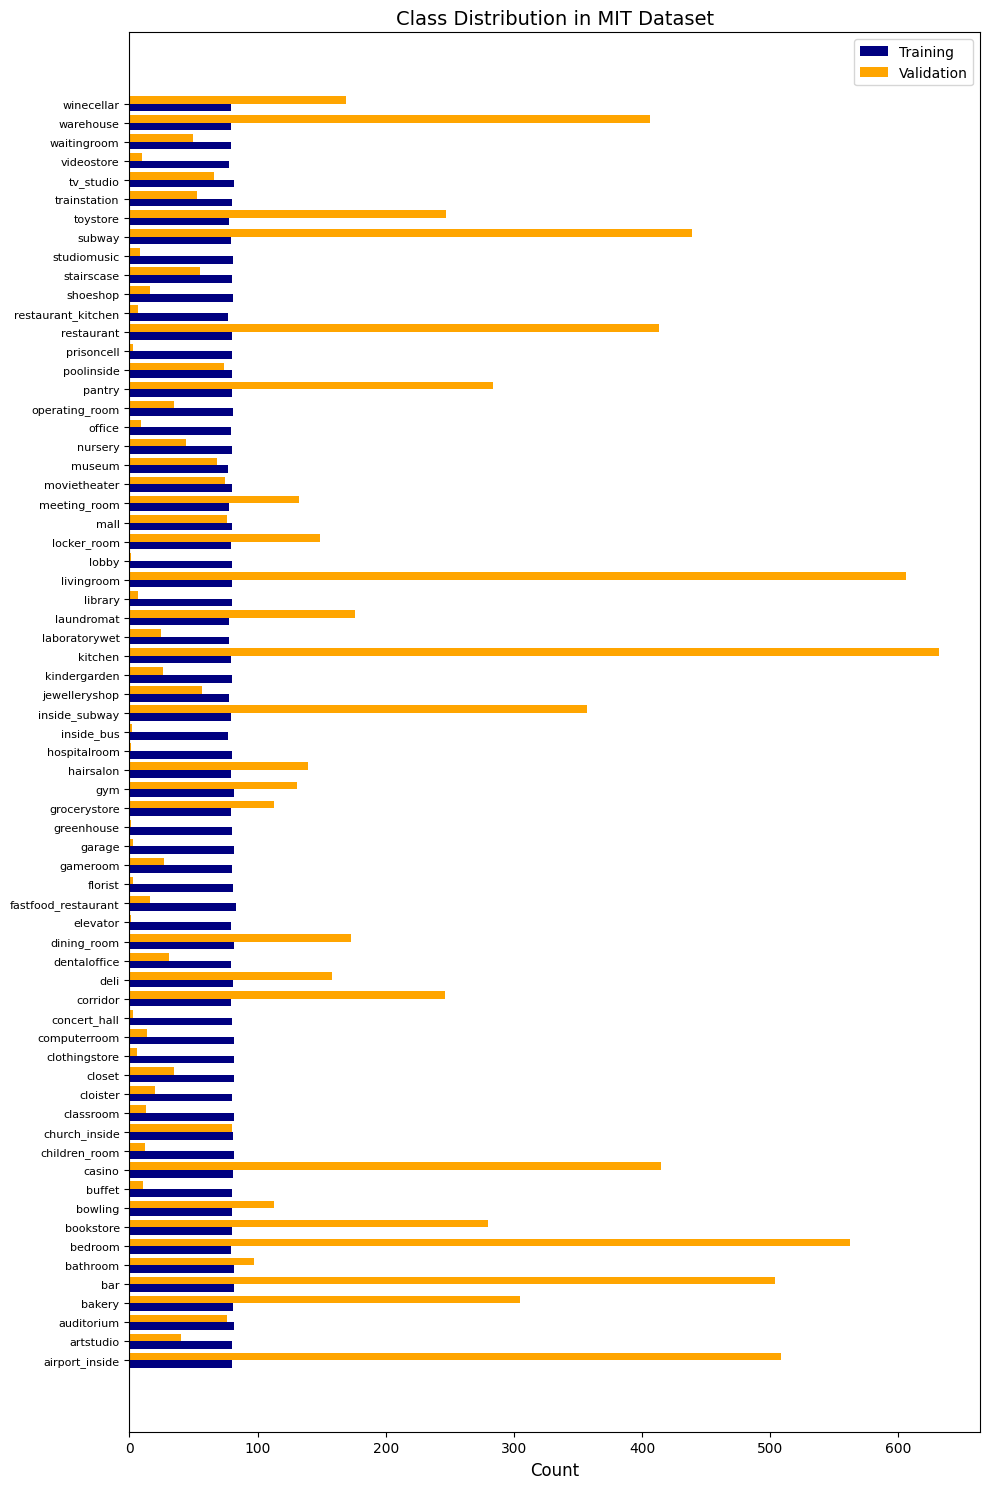

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Paths to train and validation directories
train_path = "/Users/raghavgarg/Downloads/split_data/train/"
validation_path = "/Users/raghavgarg/Downloads/split_data/validation/"

# Function to count images in each class folder
def count_images_in_folders(base_path):
    class_counts = {}
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):  # Ensure it's a folder
            class_counts[class_folder] = len(os.listdir(class_folder_path))
    return class_counts

# Count images for training and validation sets
train_counts = count_images_in_folders(train_path)
validation_counts = count_images_in_folders(validation_path)

# Ensure the order of classes is consistent
classes = sorted(train_counts.keys())  # Assuming classes are the same for train and validation
training_counts = [train_counts.get(cls, 0) for cls in classes]
validation_counts = [validation_counts.get(cls, 0) for cls in classes]

# Plotting
fig, ax = plt.subplots(figsize=(10, 15))
bar_width = 0.4
y_positions = np.arange(len(classes))

ax.barh(y_positions, training_counts, height=bar_width, label='Training', color='navy')
ax.barh(y_positions + bar_width, validation_counts, height=bar_width, label='Validation', color='orange')

# Formatting
ax.set_yticks(y_positions + bar_width / 2)
ax.set_yticklabels(classes, fontsize=8)
ax.set_xlabel('Count', fontsize=12)
ax.set_title('Class Distribution in MIT Dataset', fontsize=14)
ax.legend()

# Adjust layout for better viewing
plt.tight_layout()
plt.show()


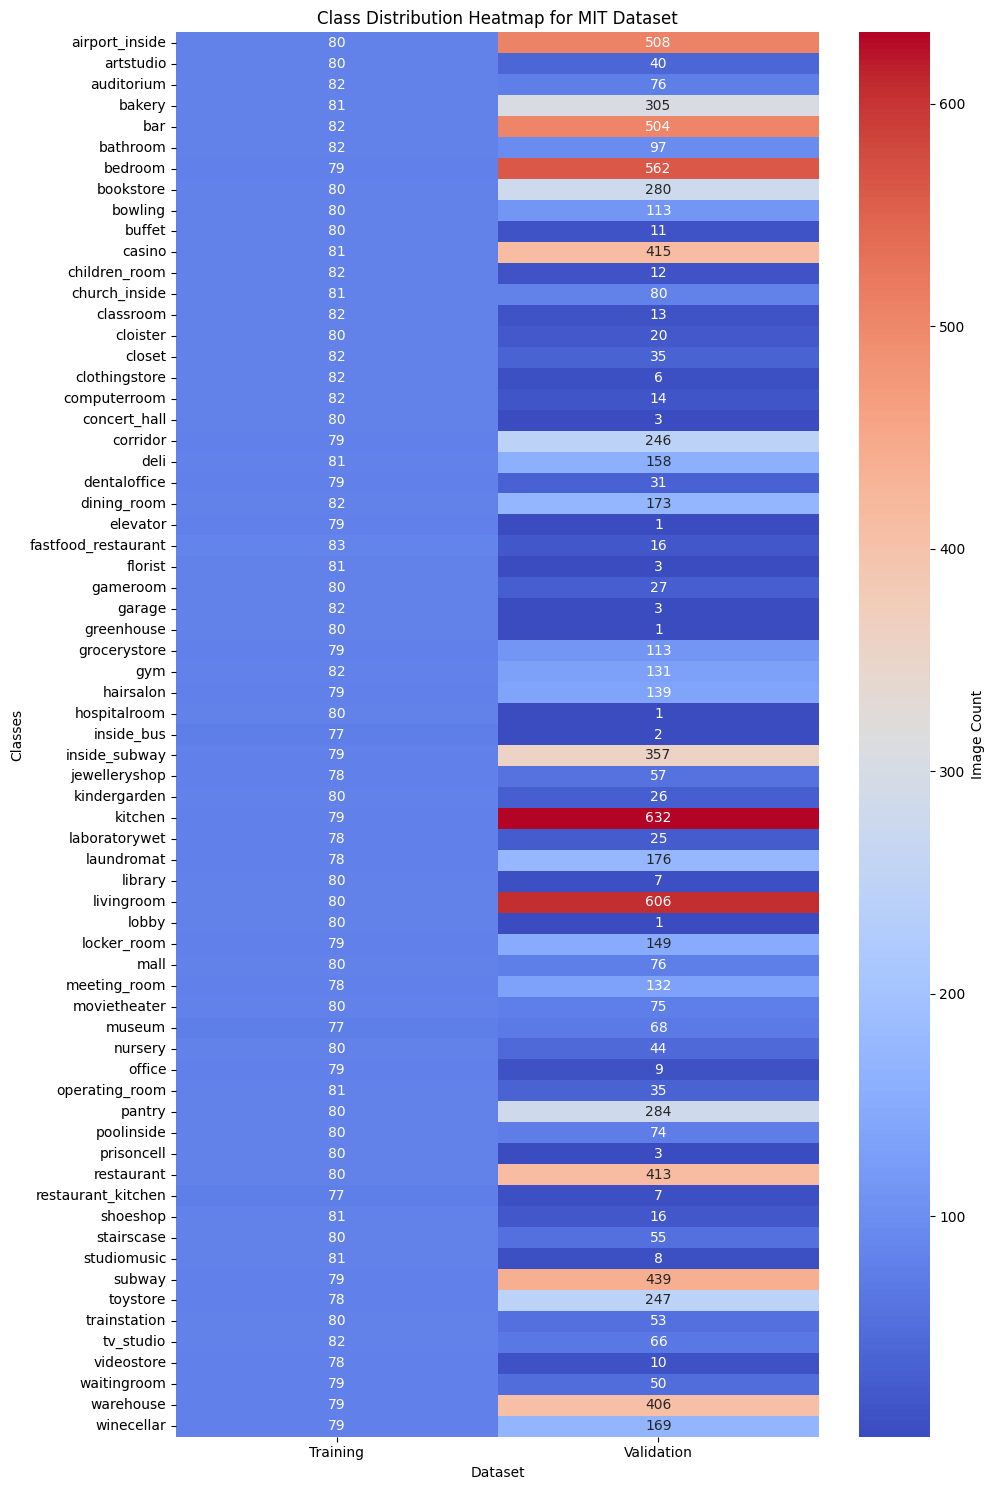

In [2]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for counts
data = {'Class': classes, 'Training': training_counts, 'Validation': validation_counts}
df = pd.DataFrame(data)

# Plot Heatmap
plt.figure(figsize=(10, 15))
sns.heatmap(df.set_index('Class'), annot=True, fmt='d', cmap='coolwarm', cbar_kws={'label': 'Image Count'})
plt.title('Class Distribution Heatmap for MIT Dataset')
plt.xlabel('Dataset')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()


In [4]:
import os

def get_dataset_stats(directory):
    class_counts = {}
    total_images = 0  # Initialize total image counter

    # Loop through each class folder in the directory
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Check if it's a folder
            image_count = len(os.listdir(class_path))  # Count files in the folder
            class_counts[class_name] = image_count
            total_images += image_count  # Add to the total count

    # Get the class with min and max images
    min_class = min(class_counts, key=class_counts.get)
    max_class = max(class_counts, key=class_counts.get)

    return {
        "min": (min_class, class_counts[min_class]),
        "max": (max_class, class_counts[max_class]),
        "total": total_images
    }

# Paths to train and validation directories
train_dir = "/Users/raghavgarg/Downloads/split_data/train/"
validation_dir = "/Users/raghavgarg/Downloads/split_data/validation/"

# Get stats for training and validation datasets
train_stats = get_dataset_stats(train_dir)
validation_stats = get_dataset_stats(validation_dir)

# Print results
print("Training Dataset:")
print(f"Class with minimum images: {train_stats['min'][0]} ({train_stats['min'][1]} images)")
print(f"Class with maximum images: {train_stats['max'][0]} ({train_stats['max'][1]} images)")
print(f"Total images: {train_stats['total']}")

print("\nValidation Dataset:")
print(f"Class with minimum images: {validation_stats['min'][0]} ({validation_stats['min'][1]} images)")
print(f"Class with maximum images: {validation_stats['max'][0]} ({validation_stats['max'][1]} images)")
print(f"Total images: {validation_stats['total']}")


Training Dataset:
Class with minimum images: restaurant_kitchen (77 images)
Class with maximum images: fastfood_restaurant (83 images)
Total images: 5360

Validation Dataset:
Class with minimum images: greenhouse (1 images)
Class with maximum images: kitchen (632 images)
Total images: 8914


In [5]:
from PIL import Image

# Open an image file
image = Image.open('/Users/raghavgarg/Downloads/split_data/train/airport_inside/airport_inside_0001.jpg')

# Get the image dimensions (width, height)
width, height = image.size

# Print the dimensions
print(f"Image Dimensions: {width} x {height}")


Image Dimensions: 500 x 368


In [6]:
from PIL import Image

# Open an image file
image = Image.open('/Users/raghavgarg/Downloads/split_data/train/airport_inside/airport_inside_0008.jpg')

# Get the image dimensions (width, height)
width, height = image.size

# Print the dimensions
print(f"Image Dimensions: {width} x {height}")


Image Dimensions: 300 x 230
